## Training pipeline

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)
# Set the environment variables from the file <root_dir>/.env
from backend.models import config
settings = config.HopsworksSettings(_env_file=f"{project_root}/.env")

HopsworksSettings initialized!


In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from backend import util
import json

import warnings
warnings.filterwarnings("ignore")

Load project.

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

2025-11-17 12:26:10,983 INFO: Initializing external client
2025-11-17 12:26:10,983 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 12:26:12,518 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279162


In [4]:
country = locals().get("country", 'sweden')
city = locals().get("city", 'stockholm')
street = locals().get("street", 'nacka')
lag_feature = locals().get("lag_feature", "pm25_lag_1")

### Prepare the data

In [5]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_with_all_lags',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [6]:
from hsfs.feature import Feature

if lag_feature == 'pm25':
    selected_features = air_quality_fg.select(
        ['pm25', 'date']
    ).join(
        weather_fg.select_features(), on=['city']
    )
else:
    selected_features = air_quality_fg.select(
        ['pm25', lag_feature, 'date']
    ).join(
        weather_fg.select_features(), on=['city']
    )

2025-11-17 12:26:14,524 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [7]:
feature_view = fs.get_or_create_feature_view(
    name=f'air_quality_fv_{lag_feature}',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [8]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start,
    primary_key=True,
)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.00s) 


,pm25_lag_1,date,lescalableframes_air_quality_with_all_lags_1_street,lescalableframes_air_quality_with_all_lags_1_country,lescalableframes_air_quality_with_all_lags_1_city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,lescalableframes_weather_1_city
0,26.00,2017-05-28 00:00:00+00:00,rahu,estonia,tallinn,20.497751,1.5,20.291357,255.617081,tallinn
1,21.00,2017-05-29 00:00:00+00:00,rahu,estonia,tallinn,14.410249,0.0,18.129137,345.427307,tallinn
2,32.00,2017-05-30 00:00:00+00:00,rahu,estonia,tallinn,10.778999,9.1,18.511143,188.213547,tallinn
3,17.00,2017-05-31 00:00:00+00:00,rahu,estonia,tallinn,11.329000,3.3,15.815435,305.566833,tallinn
4,19.00,2018-05-15 00:00:00+00:00,rahu,estonia,tallinn,18.206083,0.0,11.570515,62.949455,tallinn
...,...,...,...,...,...,...,...,...,...,...
22773,0.60,2025-04-30 00:00:00+00:00,jultomtestegen,sweden,stockholm,8.947750,1.6,25.369785,313.522400,stockholm
22774,0.30,2025-04-30 00:00:00+00:00,nacka,sweden,stockholm,8.947750,1.6,25.369785,313.522400,stockholm
22775,0.20,2025-04-30 00:00:00+00:00,hägersten,sweden,stockholm,8.947750,1.6,25.369785,313.522400,stockholm
22776,0.38,2025-04-30 00:00:00+00:00,lundströmsgata,sweden,stockholm,8.947750,1.6,25.369785,313.522400,stockholm


In [10]:
X_features = X_train[
    (X_train["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_city"] == city)
].drop(columns=['date', 
    'lescalableframes_air_quality_with_all_lags_1_country',
    'lescalableframes_air_quality_with_all_lags_1_city',
    'lescalableframes_weather_1_city'
])[3:]
X_test_features = X_test[
    (X_test["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_city"] == city)
].drop(columns=['date',
    'lescalableframes_air_quality_with_all_lags_1_country',
    'lescalableframes_air_quality_with_all_lags_1_city',
    'lescalableframes_weather_1_city'
])

In [11]:
X_features

,pm25_lag_1,lescalableframes_air_quality_with_all_lags_1_street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2255,7.00,stockholm-hornsgatan-108-gata,6.964418,0.300000,22.771244,309.045013
2256,12.00,stockholm-hornsgatan-108-gata,6.922750,1.400000,13.684735,273.607208
2257,12.00,stockholm-hornsgatan-108-gata,10.216500,13.299999,20.192118,211.184906
2258,10.00,stockholm-hornsgatan-108-gata,8.006085,2.500000,28.856194,326.976105
2259,9.00,stockholm-hornsgatan-108-gata,11.681083,2.300000,20.833395,249.373688
...,...,...,...,...,...,...
22773,0.60,jultomtestegen,8.947750,1.600000,25.369785,313.522400
22774,0.30,nacka,8.947750,1.600000,25.369785,313.522400
22775,0.20,hägersten,8.947750,1.600000,25.369785,313.522400
22776,0.38,lundströmsgata,8.947750,1.600000,25.369785,313.522400


In [12]:
y_train = y_train[
    (X_train["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_train["lescalableframes_air_quality_with_all_lags_1_city"] == city)
][3:]
y_train

,pm25
2255,12.00
2256,12.00
2257,10.00
2258,9.00
2259,11.00
...,...
22773,0.70
22774,0.47
22775,0.30
22776,0.40


In [13]:
y_test = y_test[
    (X_test["lescalableframes_air_quality_with_all_lags_1_country"] == country) &
    (X_test["lescalableframes_air_quality_with_all_lags_1_city"] == city)
]
y_test

,pm25
22778,20.00
22779,18.00
22780,1.42
22781,0.10
22782,0.00
...,...
25287,2.00
25288,5.00
25289,2.00
25290,3.00


### Train the model

In [14]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(
    X_features.drop(
        columns=['lescalableframes_air_quality_with_all_lags_1_street']
    ), 
    y_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(
    X_test_features.drop(
        columns=['lescalableframes_air_quality_with_all_lags_1_street']
    )
)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 28.052595
R squared: 0.7376168460593497


In [16]:
df = y_test
df['predicted_pm25'] = y_pred

In [17]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
22778,20.00,19.896538,2025-05-01 00:00:00+00:00
22790,1.30,-0.847692,2025-05-01 00:00:00+00:00
22789,1.00,-0.923698,2025-05-01 00:00:00+00:00
22788,0.98,-0.993714,2025-05-01 00:00:00+00:00
22786,1.17,-0.619807,2025-05-01 00:00:00+00:00


In [18]:
street_new = street.replace('-', '_')
street_new = street_new.replace('ä', 'ae')
street_new = street_new.replace('ö', 'oe')
street_new = street_new.replace('å', 'oa')

In [19]:
model_dir = f"backend/air_quality_models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

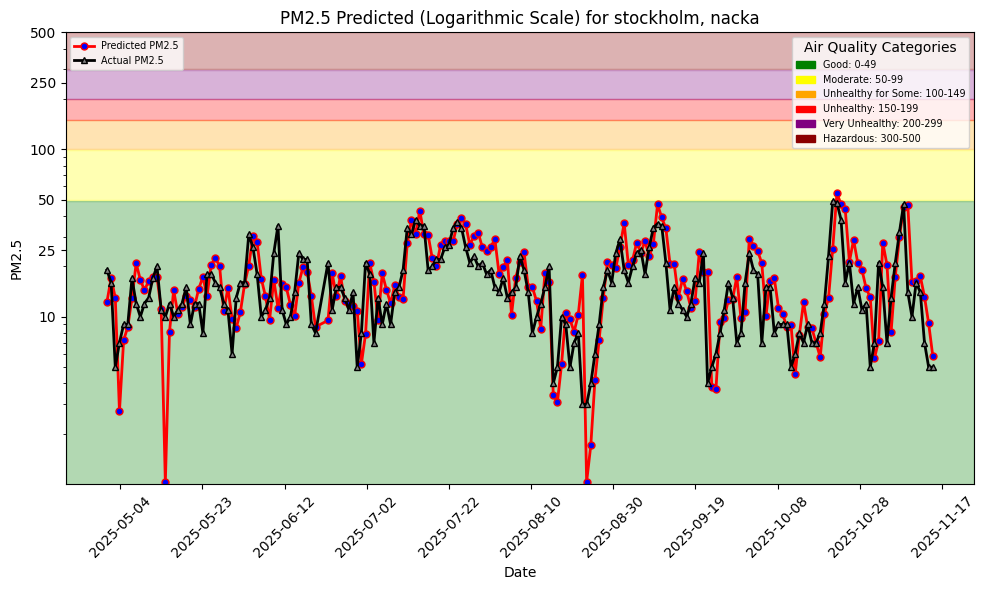

In [20]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(
    city, 
    street, 
    df[X_test_features['lescalableframes_air_quality_with_all_lags_1_street'] == 'sollentuna-sollentunavagen-192'], 
    file_path, 
    hindcast=True) 
plt.show()

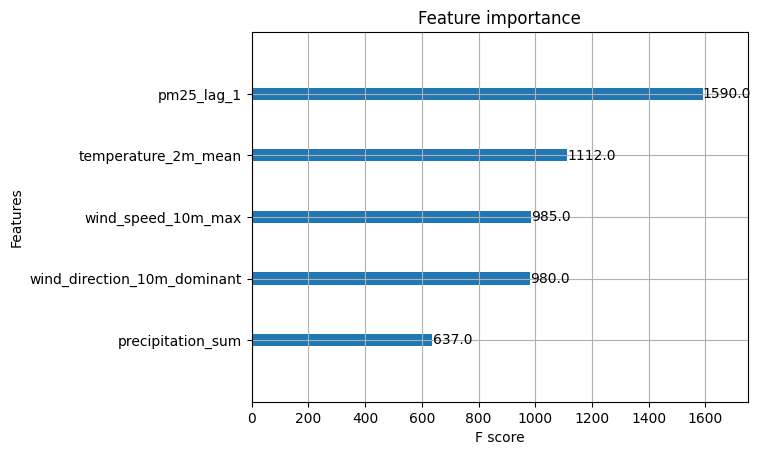

In [21]:
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### Saving the model

In [22]:
xgb_regressor.save_model(model_dir + "/model_all_sensors.json")

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
print(model_dir)

backend/air_quality_models


In [25]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_general", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/backend/air_qu…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/backend/air_qu…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/backend/air_qu…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/backend/air_qu…

Uploading /Users/jonaslorenz/Desktop/Code_KTH/ScalableML/AirQualityPrediction/backend/notebooks/model_schema.j…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279162/models/air_quality_xgboost_model_general/1


Model(name: 'air_quality_xgboost_model_general', version: 1)